In [1]:
import os
import pandas as pd
import numpy as np
import requests
import json
import glob
import re
import seaborn as sns
from matplotlib import pyplot as plt
from monty.serialization import loadfn

Select desired values for booleans:

In [2]:
#Set to True if using charge_throughput as response variable, False if using cycle life (X.capacity_0.8)
ct = True

#True if training on old data and testing on new data, false if mixing both old and new data into train and test set
#Only applies to when old and new data are combined
train_old_test_new = False

#True if including 'X.integrated_time_temperature_cycles_1:100' to full model, False if not
integrated_time_temp_cycles = False

#True if applying a log transformtion to combined data, False if no transformation
log_transformation = True

#True if including internal resistance for old data, false if not (no internal resistance variable for new data)
ir = False

#True if standardizing explanatory variables, false otherwise (necessary for elastic net)
standardized = True

In [3]:
path = "E:/Data/TRI/"
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")

In [4]:
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [5]:
variance_model_features = 'X.abs_variance_discharge_capacity_difference_cycles_2:100'
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5']

if integrated_time_temp_cycles:
    full_model_features.append('X.integrated_time_temperature_cycles_1:100')

if ir:
    full_model_features.append('X.min_internal_resistance_cycles_2:100')
    full_model_features.append('X.internal_resistance_difference_cycles_2:100')

if ct:
    y = 'charge_throughput'
else:
    y = 'cycle_index'

In [6]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

## Old Data

<AxesSubplot:xlabel='X.abs_variance_discharge_capacity_difference_cycles_2:100', ylabel='charge_throughput'>

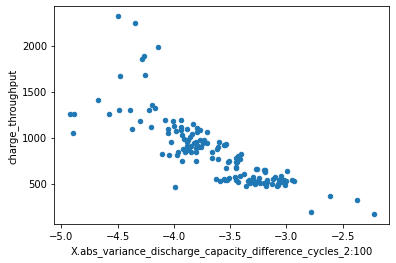

In [7]:
old_ct.plot.scatter(x='X.abs_variance_discharge_capacity_difference_cycles_2:100', y = y)

In [8]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]

In [9]:
if standardized:
    
    all_model_features = full_model_features + list(set(discharge_model_features)-set(full_model_features))

    def standardize(data_subset):
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data_subset)
        scaled_df = pd.DataFrame(scaled_data, index=data_subset.index, columns=data_subset.columns)
        return scaled_df

    old_ct[all_model_features] = standardize(old_ct[all_model_features])   

### Variance Model

In [10]:
# Variance model
X_train_var = old_ct.iloc[train_ind][[variance_model_features]]
y_train = old_ct.iloc[train_ind][[y]]

X_test_var = old_ct.iloc[test_ind][[variance_model_features]]
y_test = old_ct.iloc[test_ind][[y]]

In [11]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  282.92191713852736
Test RMSE:  214.30059910503815
Mean % Train Error:  0.21885733342950425
Mean % Test Error:  0.1485010582836219


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

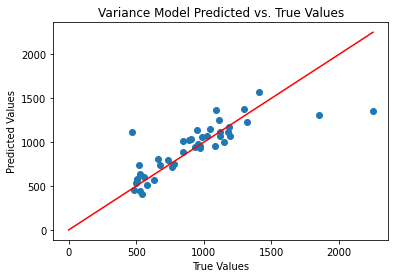

In [12]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

In [13]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
#     mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)
#     mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)

Variance Elastic Net Model
l1_ratio = 1.0
Test RMSE:  214.3149092173106


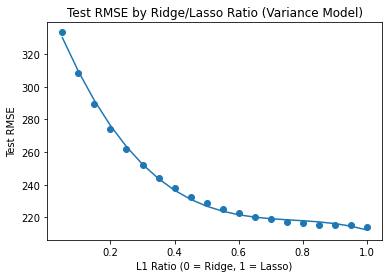

In [14]:
coeffs = np.polyfit(l1_ratios, test_rmses, 3)
vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

plt.scatter(l1_ratios, test_rmses)
plt.plot(l1_ratios, vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN)')

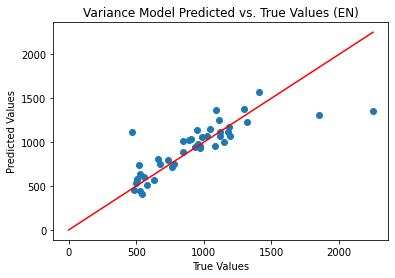

In [15]:
#Elastic Net
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN)")

#### From paper (Variance Model)
* Training RMSE: 103
* Test RMSE: 138
* Mean % Train Error: 14.1
* Mean % Test Error: 14.7

### Discharge Model

In [16]:
# discharge model
X_train_dis = old_ct.iloc[train_ind][discharge_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_dis = old_ct.iloc[test_ind][discharge_model_features]
y_test = old_ct.iloc[test_ind][[y]]

reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))

Discharge Basic Linear Regression Model
Training RMSE:  198.98052994567502
Test RMSE:  335.3509910185471


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

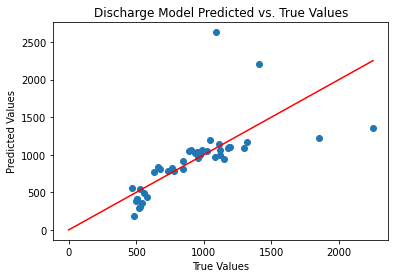

In [17]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

In [18]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
#     mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)
#     mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.25
Test RMSE:  248.28771893774592


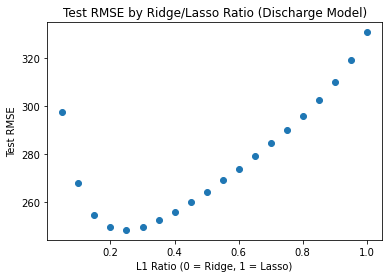

In [19]:
# coeffs = np.polyfit(l1_ratios, test_rmses, 3)
# vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios[:-1]]

plt.scatter(l1_ratios, test_rmses)
# plt.plot(l1_ratios[:-1], vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN)')

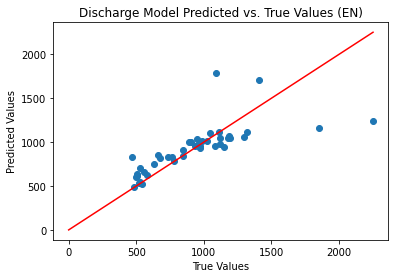

In [20]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN)")

#### From paper (Discharge Model)
* Training RMSE: 76
* Test RMSE: 91
* Mean % Train Error: 9.8
* Mean % Test Error: 13.0

### Full Model

In [21]:
# full model
X_train_full = old_ct.iloc[train_ind][full_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_full = old_ct.iloc[test_ind][full_model_features]
y_test = old_ct.iloc[test_ind][[y]]

reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  197.8047151700737
Test RMSE:  216.1417833155751
Mean % Train Error:  0.15589873508454066
Mean % Test Error:  0.16906215860652746


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

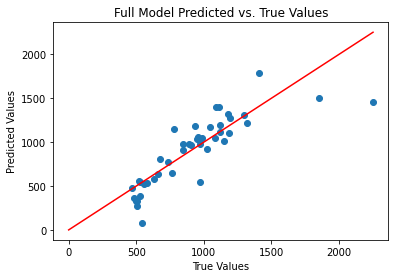

In [22]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

In [23]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]   #use this when testing different ratios
#l1_ratios = [0.8]   #use this when using only the best ratio
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
#     mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)
#     mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)

Full Elastic Net Model
l1_ratio = 0.8
Test RMSE:  199.95973540938738


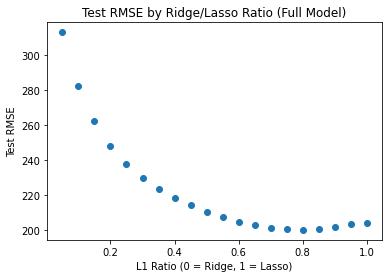

In [24]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN)')

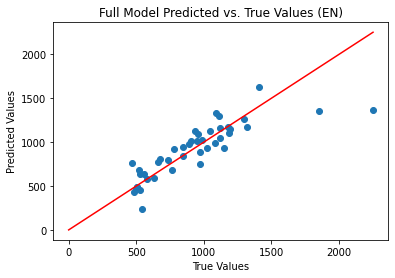

In [25]:
#Elastic Net
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN)")

#### From paper (Full Model)
* Training RMSE: 51
* Test RMSE: 118
* Mean % Train Error: 5.6
* Mean % Test Error: 14.1

### Old Data Plots

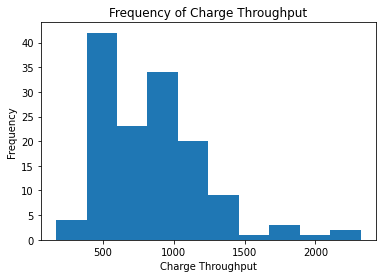

In [26]:
plt.hist(old_ct[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life')

In [27]:
old_data_metrics = pd.DataFrame(data = {"Model & Source": ["Var (Linear)", "Var (E.N.)", "Var (Paper)",
                                                           "Disc (Linear)", "Disc (E.N.)", "Disc (Paper)",
                                                           "Full (Linear)", "Full (E.N.)", "Full (Paper)"],
                               
                               "Model": ["Variance", "Variance", "Variance",
                                         "Discharge", "Discharge", "Discharge",
                                         "Full", "Full", "Full"],
                                        
                               "Source": ["Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)",
                                          "Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)",
                                          "Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en, 103,
                                              rmse_train_dis, rmse_train_dis_en, 76,
                                              rmse_train_full, rmse_train_full_en, 51],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en, 138,
                                             rmse_test_dis, rmse_test_dis_en, 91, 
                                             rmse_test_full, rmse_test_full_en, 118]})#,
                               
#                                "Mean % Train Error": [mape_train_var, 14.1,
#                                                       mape_train_dis, 9.8,
#                                                       mape_train_full, 5.6],
                               
#                                "Mean % Test Error": [mape_test_var, 14.7,
#                                                      mape_test_dis, 13.0,
#                                                      mape_test_full, 14.1]})

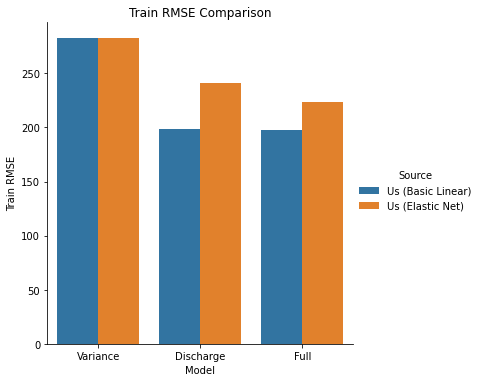

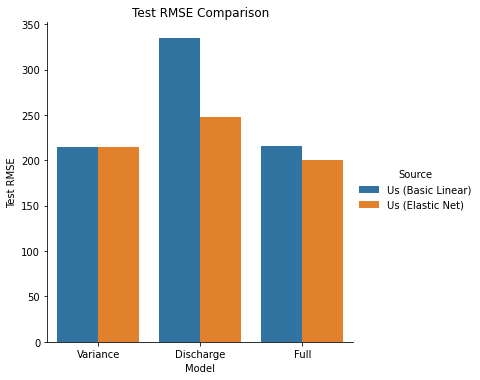

In [28]:
if ct:
    old_data_metrics = old_data_metrics.iloc[[0,1,3,4,6,7]]
for column in old_data_metrics.columns[3:5]:
    sns.catplot(data = old_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison")

In [29]:
#Removing internal_resistance features for models with new data
if ir:
    full_model_features.remove('X.min_internal_resistance_cycles_2:100')
    full_model_features.remove('X.internal_resistance_difference_cycles_2:100')
    
    if standardized:
        all_model_features.remove('X.min_internal_resistance_cycles_2:100')
        all_model_features.remove('X.internal_resistance_difference_cycles_2:100')

## New Data

In [30]:
new_df = pd.read_csv(path + "NewData/LFPBatteries.csv")

In [31]:
new_ct["battery_index"] = new_ct["battery"].str[-2:].astype('int')

In [32]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, left_index = True, right_on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [33]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

# Note:

When running the code below, the rows with NA are not removed, but then every value in those rows is NA. In order to preserve the same train/test indices, I'll just let all values in the row be NA and remove them when it comes to the train/test subsets

Also unrelated, but we may want to deal with the fact that there's a lot of 0's in columns that are otherwise negative

In [34]:
# new_ct_full[all_model_features] = new_ct_full[all_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
# new_ct_full[all_model_features]

When adding the dropna to the function, it still doesn't save the removal of the NA, but it's still able to standardize the data. After dropping the NA values in their respective X_train and y_train variables, it works like normal but its still chunky

In [35]:
if standardized:
    new_ct_full[all_model_features] = standardize(
        new_ct_full[all_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    )

In [36]:
new_ct_full[all_model_features]

,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.slope_discharge_capacity_cycle_number_2:100,X.intercept_discharge_capacity_cycle_number_2:100,X.discharge_capacity_cycle_2,X.charge_time_cycles_1:5,X.max_discharge_capacity_difference,X.abs_skew_discharge_capacity_difference_cycles_2:100,X.abs_kurtosis_discharge_capacity_difference_cycles_2:100
0,0.278786,-0.363773,0.733665,0.493703,-1.342728,-1.589960,0.536171,0.962272,1.238771
1,0.632221,-0.298061,0.712975,0.541546,-0.599716,-0.835400,0.558486,1.985811,1.894601
2,0.651738,0.046706,0.731521,0.485334,-1.342728,-0.080841,0.519434,1.140173,1.004235
3,0.004205,-0.253252,0.652853,0.475126,-1.417029,-0.835400,0.511066,-0.357525,0.734554
4,0.660993,0.754409,0.394272,0.659996,1.406415,-0.835400,0.644959,-1.051520,-0.762978
5,0.397569,0.112049,0.651911,0.491681,-1.194126,-0.835400,0.527802,0.868168,0.377817
6,0.732282,0.159510,0.682540,0.516539,-0.971222,-0.835400,0.544539,1.533198,1.045521
7,0.265844,0.051896,0.660908,0.575209,0.143295,-0.835400,0.572434,-0.810702,-0.213508
8,0.161544,0.049475,0.660778,0.569185,0.068994,-0.835400,0.572434,-0.808254,-0.329560
9,0.215535,-0.311157,0.659998,0.496296,-0.896921,-0.080841,0.513855,1.279803,1.060588


### Variance Model

In [37]:
# Variance model
X_train_var = new_ct_full.iloc[train_ind][[variance_model_features]]
X_train_var.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_var.index][[y]]

X_test_var = new_ct_full.iloc[test_ind][[variance_model_features]]
X_test_var.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_var.index][[y]]

In [38]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  449.98867908663084
Test RMSE:  529.778684856448
Mean % Train Error:  0.11801460864220713
Mean % Test Error:  0.12012017579731393


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (LR)')

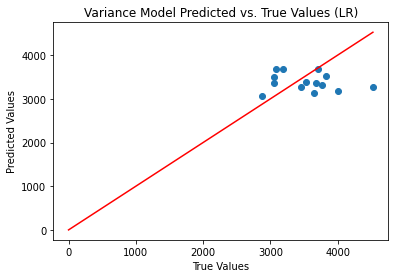

In [39]:
# Linear Regression
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (LR)")

In [40]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
#     mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)
#     mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)

Variance Elastic Net Model
l1_ratio = 0.05
Test RMSE:  488.7757330979528


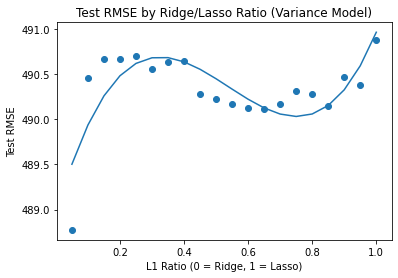

In [41]:
coeffs = np.polyfit(l1_ratios, test_rmses, 3)
vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

plt.scatter(l1_ratios, test_rmses)
plt.plot(l1_ratios, vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN)')

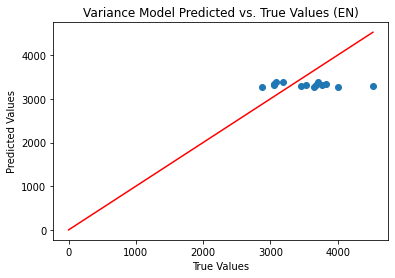

In [42]:
#Elastic Net
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN)")

### Discharge Model

In [43]:
# discharge model
X_train_dis = new_ct_full.iloc[train_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_dis.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_dis.index][[y]]

X_test_dis = new_ct_full.iloc[test_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_dis.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_dis.index][[y]]

reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
# print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Training RMSE:  332.6158412163995
Test RMSE:  543.4380606624101


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (LR)')

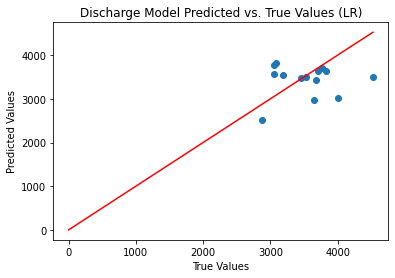

In [44]:
# Linear Regression
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (LR)")

In [45]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
#     mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)
#     mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.7
Test RMSE:  460.05411079250257


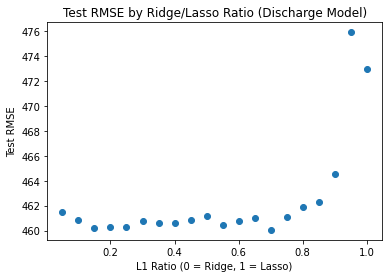

In [46]:
# coeffs = np.polyfit(l1_ratios, test_rmses, 3)
# vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios[:-1]]

plt.scatter(l1_ratios, test_rmses)
# plt.plot(l1_ratios[:-1], vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN)')

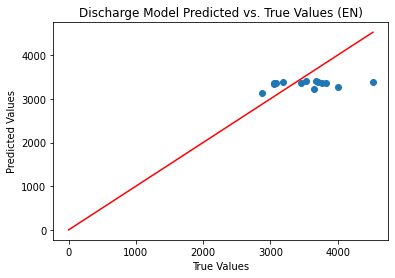

In [47]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN)")

### Full Model

In [48]:
# full model
X_train_full = new_ct_full.iloc[train_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_full.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_full.index][[y]]

X_test_full = new_ct_full.iloc[test_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_full.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_full.index][[y]]

reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  247.5240462879026
Test RMSE:  358.2227320761944
Mean % Train Error:  0.05047357250148093
Mean % Test Error:  0.07582388910734303


Text(0.5, 1.0, 'Full Model Predicted vs. True Values (LR)')

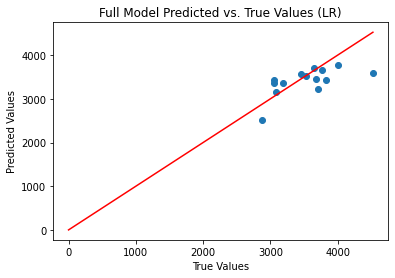

In [49]:
#Linear Regression
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (LR)")

In [50]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]   #use this when testing different ratios
#l1_ratios = [0.8]   #use this when using only the best ratio
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )
    
    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
#     mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)
#     mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)

Full Elastic Net Model
l1_ratio = 1.0
Test RMSE:  466.29998279160793


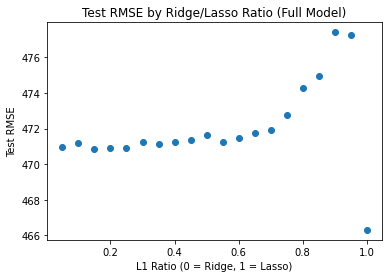

In [51]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN)')

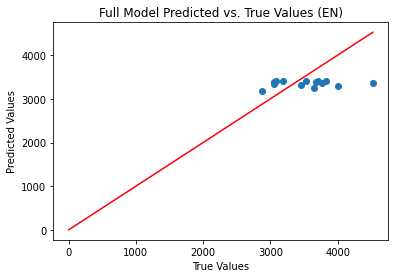

In [52]:
#Elastic Net
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN)")

### New Data Plots

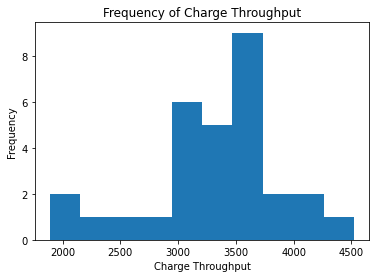

In [53]:
plt.hist(new_ct_full[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life (New Data)')

In [54]:
new_data_metrics = pd.DataFrame(data = {"Model & Source": ["Var (Linear)", "Var (E.N.)", 
                                                           "Disc (Linear)", "Disc (E.N.)",
                                                           "Full (Linear)", "Full (E.N.)"],
                               
                               "Model": ["Variance", "Variance",
                                         "Discharge", "Discharge",
                                         "Full", "Full"],
                                        
                               "Source": ["Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en,
                                              rmse_train_dis, rmse_train_dis_en,
                                              rmse_train_full, rmse_train_full_en],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en,
                                             rmse_test_dis, rmse_test_dis_en,
                                             rmse_test_full, rmse_test_full_en,]})#,

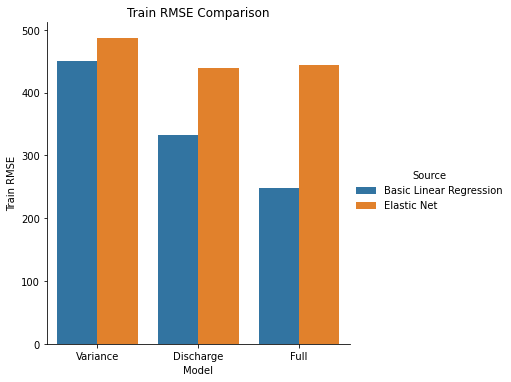

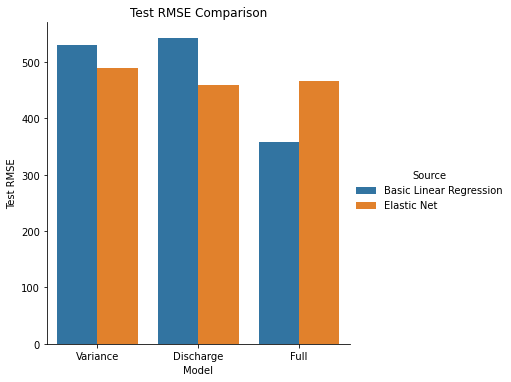

In [55]:
for column in new_data_metrics.columns[3:5]:
    sns.catplot(data = new_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison")

## New + Old Data

In [56]:
old_ct["Source"] = -1
new_ct_full["Source"] = 1
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

variance_model_features = [variance_model_features, "Source"]
discharge_model_features.append("Source")
full_model_features.append("Source")

In [57]:
full_data["Source"]

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
164    1
165    1
166    1
167    1
168    1
Name: Source, Length: 169, dtype: int64

In [58]:
if train_old_test_new:
    train_ind = [i for i in range(1,83)]
    test_ind = [j for j in range(139,168)]
    
else:
    train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
            35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
            69, 71, 73, 75, 77, 79, 81]
    test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
            34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
            68, 70, 72, 74, 76, 78, 80, 82, 83]

    train_ind = train_ind + list(range(old_ct.shape[0],old_ct.shape[0] + new_ct.shape[0], 2))
    test_ind = test_ind + list(range(old_ct.shape[0] + 1,old_ct.shape[0] + new_ct.shape[0], 2))

### Variance Model

In [59]:
# Variance model
X_train_var = full_data.iloc[train_ind][variance_model_features]
X_train_var.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = full_data.iloc[X_train_var.index][[y]]

X_test_var = full_data.iloc[test_ind][variance_model_features]
X_test_var.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = full_data.iloc[X_test_var.index][[y]]

# log transformation
if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [60]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_var = np.exp(y_pred_train_var)
    y_pred_test_var = np.exp(y_pred_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  568.7519991655892
Test RMSE:  925.0036086055247
Mean % Train Error:  0.20600848465352561
Mean % Test Error:  0.22272252381417632


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

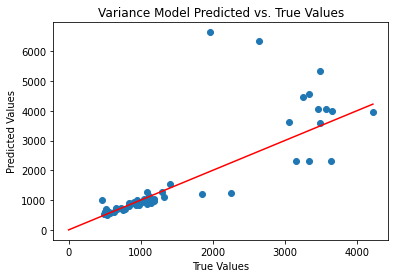

In [61]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

In [62]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    if log_transformation:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
        
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )
    
    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    if log_transformation:
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        y_pred_train_en_var = np.exp(y_pred_train_en_var)
        y_pred_test_en_var = np.exp(y_pred_test_en_var)
    
    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
#     mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)
#     mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)

Variance Elastic Net Model
l1_ratio = 0.05
Test RMSE:  889.0207193522176


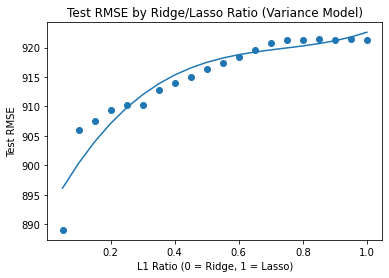

In [63]:
coeffs = np.polyfit(l1_ratios, test_rmses, 3)
vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

plt.scatter(l1_ratios, test_rmses)
plt.plot(l1_ratios, vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN)')

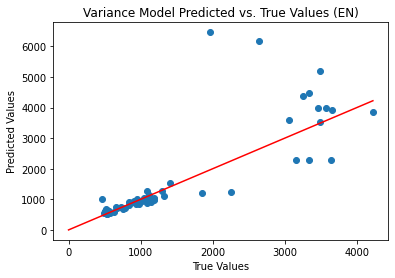

In [64]:
#Elastic Net
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN)")

### Discharge Model

In [65]:
full_data.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan).isna().sum()

X.abs_min_discharge_capacity_difference_cycles_2:100         1
X.abs_variance_discharge_capacity_difference_cycles_2:100    1
X.abs_skew_discharge_capacity_difference_cycles_2:100        1
X.abs_kurtosis_discharge_capacity_difference_cycles_2:100    1
X.discharge_capacity_cycle_2                                 1
X.max_discharge_capacity_difference                          1
Source                                                       0
dtype: int64

In [66]:
# discharge model
X_train_dis = full_data.iloc[train_ind][discharge_model_features]#.replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
X_train_dis.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = full_data.iloc[X_train_dis.index][[y]]

X_test_dis = full_data.iloc[test_ind][discharge_model_features]#.replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
X_test_dis.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = full_data.iloc[X_test_dis.index][[y]]

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)
    
reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_dis = np.exp(y_pred_train_dis)
    y_pred_test_dis = np.exp(y_pred_test_dis)
    
rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
# print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Training RMSE:  612.1862471534879
Test RMSE:  946.8080740437202


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

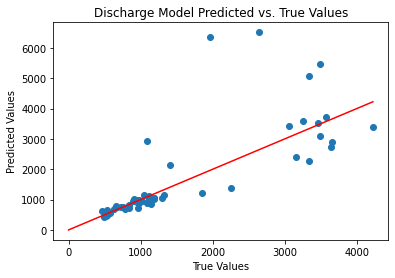

In [67]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

In [68]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    if log_transformation:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
    
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    if log_transformation:
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        y_pred_train_en_dis = np.exp(y_pred_train_en_dis)
        y_pred_test_en_dis = np.exp(y_pred_test_en_dis)

    
    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
#     mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)
#     mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.4
Test RMSE:  881.9388556770517


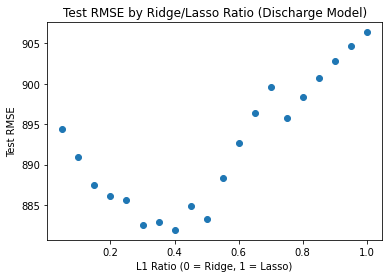

In [69]:
# coeffs = np.polyfit(l1_ratios, test_rmses, 3)
# vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios[:-1]]

plt.scatter(l1_ratios, test_rmses)
# plt.plot(l1_ratios[:-1], vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN)')

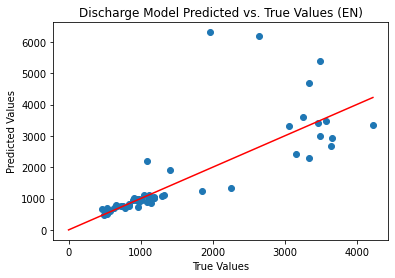

In [70]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN)")

### Full Model

In [71]:
# full model
X_train_full = full_data.iloc[train_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
X_train_full.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = full_data.loc[X_train_full.index][[y]]

X_test_full = full_data.iloc[test_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
X_test_full.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = full_data.loc[X_test_full.index][[y]]

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_full = np.exp(y_pred_train_full)
    y_pred_test_full = np.exp(y_pred_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  345.22210386847763
Test RMSE:  824.515847248168
Mean % Train Error:  0.13887414137762719
Mean % Test Error:  0.21114031457091467


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

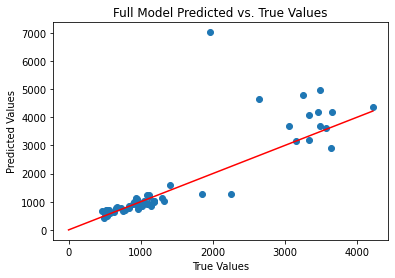

In [72]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

In [73]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]   #use this when testing different ratios
#l1_ratios = [0.8]   #use this when using only the best ratio
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    if log_transformation:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
        
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    if log_transformation:
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        y_pred_train_en_full = np.exp(y_pred_train_en_full)
        y_pred_test_en_full = np.exp(y_pred_test_en_full)
        
    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
#     mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)
#     mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)

Full Elastic Net Model
l1_ratio = 0.05
Test RMSE:  737.0662227103847


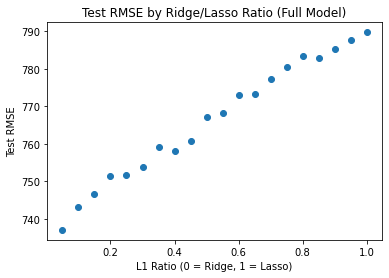

In [74]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN)')

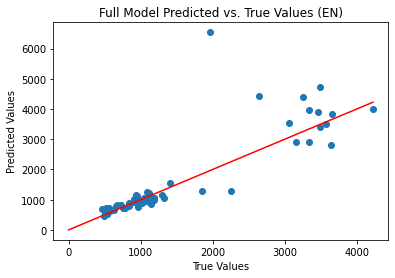

In [75]:
#Elastic Net
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN)")

## Old + New Data Plots

C:\Users\david\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


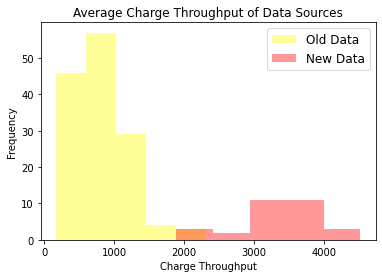

In [76]:
sns.distplot(old_ct[y], kde=False, color="yellow", label='Old Data', bins=5)
sns.distplot(new_ct_full[y], kde=False, color="red", label='New Data', bins=5)

# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

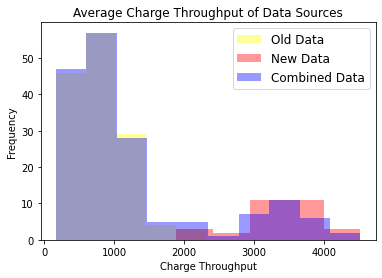

In [77]:
sns.distplot(old_ct[y], kde=False, color="yellow", label='Old Data', bins=5)
sns.distplot(new_ct_full[y], kde=False, color="red", label='New Data', bins=5)
sns.distplot(full_data[y], kde = False, color = "blue", label = 'Combined Data', bins = 10)
# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

In [78]:
all_data_metrics = pd.DataFrame(data = {"Model & Source": ["Var (Linear)", "Var (E.N.)", 
                                                           "Disc (Linear)", "Disc (E.N.)",
                                                           "Full (Linear)", "Full (E.N.)"],
                               
                               "Model": ["Variance", "Variance",
                                         "Discharge", "Discharge",
                                         "Full", "Full"],
                                        
                               "Source": ["Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en,
                                              rmse_train_dis, rmse_train_dis_en,
                                              rmse_train_full, rmse_train_full_en],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en,
                                             rmse_test_dis, rmse_test_dis_en,
                                             rmse_test_full, rmse_test_full_en,]})#,

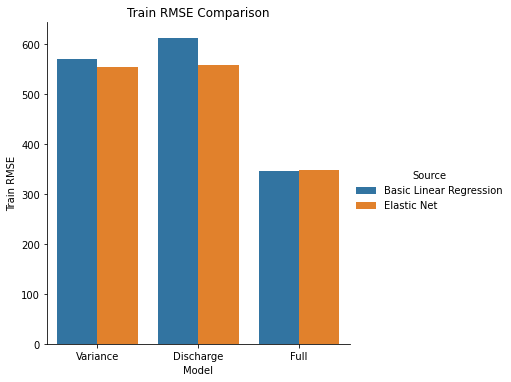

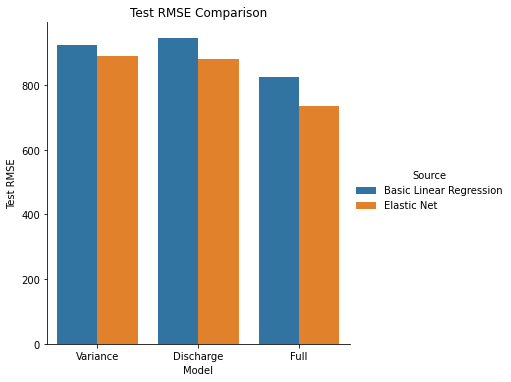

In [79]:
for column in all_data_metrics.columns[3:5]:
    sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison")